# Download the Data

In [3]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [4]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/30/25 10:30:42] INFO     Found credentials from IAM Role:                                   ]8;id=868188;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=78212;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [5]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [6]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [7]:
images[0]

'english_cocker_spaniel_99.jpg'

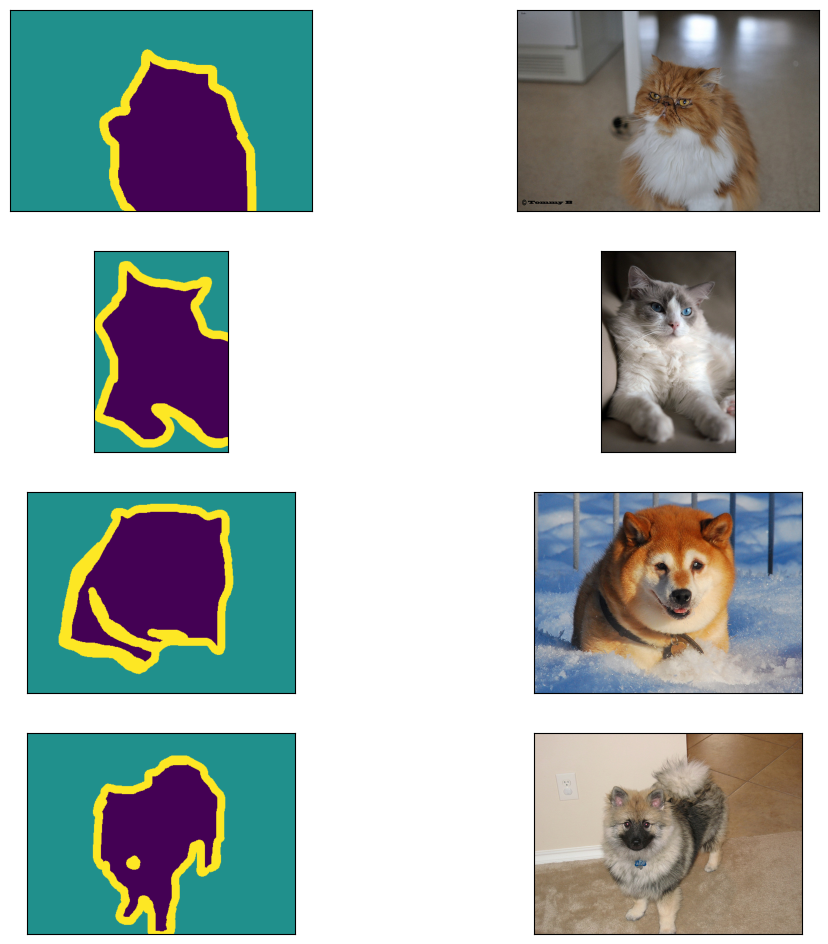

In [8]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [9]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [10]:
role=sagemaker.get_execution_role()
bucket_name='pets-data-303'
training_image=get_image_uri(boto3.Session().region_name,'semantic-segmentation',repo_version='latest')
print(training_image)

[03/30/25 10:31:03] INFO     Found credentials from IAM Role:                                   ]8;id=942001;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=474085;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/30/25 10:31:04] WARNING  The method get_image_uri has been renamed in sagemaker>=2.          ]8;id=840461;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=320012;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=161358;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=891263;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=929817;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=397487;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


In [11]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [12]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:18<00:00, 399.33it/s]


In [13]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [14]:
print(len(train_annots), len(train_images))

5467 5467


# Uploading Data to S3

In [15]:
sess=sagemaker.Session()
print('Starting Upload')
s3_train_path=sess.upload_data(path='train',bucket=bucket_name,key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path=sess.upload_data(path='train_annotation',bucket=bucket_name,key_prefix='train_annotation')
print('Training annotations uploaded')
s3_validation_path=sess.upload_data(path='validation',bucket=bucket_name,key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path=sess.upload_data(path='validation_annotation',bucket=bucket_name,key_prefix='validation_annotation')
print('Validation annotations uploaded')

[03/30/25 10:31:34] INFO     Found credentials from IAM Role:                                   ]8;id=178919;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=739829;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Starting Upload
Training images uploaded
Training annotations uploaded
Validation images uploaded
Validation annotations uploaded


In [16]:
s3_validation_annotation_path

's3://pets-data-303/validation_annotation'

# SageMaker Estimator

In [17]:
model=sagemaker.estimator.Estimator(training_image,
                                    role=role,
                                    train_instance_count=1,
                                    train_instance_type='ml.p3.2xlarge',
                                    train_volume_size=100,
                                    train_max_run=36000,
                                    input_mode='File',
                                   output_path='s3://pets-data-303/output',
                                   sagemaker_session=sess)

[03/30/25 10:44:40] WARNING  train_instance_count has been renamed in sagemaker>=2.              ]8;id=215748;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=714307;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_instance_type has been renamed in sagemaker>=2.               ]8;id=785698;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=644146;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_max_run has been renamed in sagemaker>=2.                     ]8;id=157669;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=890730;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  train_volume_size has been renamed in sagemaker>=2.                 ]8;id=637690;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=96916;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Found credentials from IAM Role:                                   ]8;id=987717;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=657143;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

# Hyperparameters

In [18]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
)

# Data Channels

In [19]:
train_data=sagemaker.session.s3_input(s3_train_path,distribution='FullyReplicated',content_type='image/jpeg',s3_data_type='S3Prefix')
validation_data=sagemaker.session.s3_input(s3_validation_path,distribution='FullyReplicated',content_type='image/jpeg',s3_data_type='S3Prefix')
train_annotation_data=sagemaker.session.s3_input(s3_train_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')
validation_annotation_data=sagemaker.session.s3_input(s3_validation_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=946768;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=643519;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=414936;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=587044;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=399571;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=425966;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    WARNING  The class sagemaker.session.s3_input has been renamed in            ]8;id=83;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=205645;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             sagemaker>=2.                                                                         
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [20]:
data_channel={
    'train':train_data,
    'validation':validation_data,
    'train_annotation':train_annotation_data,
    'validation_annotation':validation_annotation_data,
}

In [21]:
data_channel

{'train': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f994f35c4c0>,
 'validation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f994f35c7c0>,
 'train_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f994f35f0a0>,
 'validation_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f994f35c370>}

# Model Training

In [ ]:
model.fit(inputs=data_channel,logs=True)

[03/30/25 12:17:12] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=424619;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=431857;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=461170;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=825528;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             semantic-segmentation-2025-03-30-12-17-12-571                                         

2025-03-30 12:17:13 Starting - Starting the training job
.....03-30 12:17:13 Pending - Training job waiting for capacity.
.....03-30 12:18:18 Pending - Preparing the instances for training.
..25-03-30 12:18:51 Downloading - Downloading input data.
....................Downloading - Downloading the training image.
2025-03-30 12:22:53 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Mar 30 12:23:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp

# Deploy Model

In [ ]:
deployed_model=model.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')
print('\nModel Deployed!!')

[03/30/25 13:08:31] INFO     Creating model with name:                                              ]8;id=13881;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=657563;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             semantic-segmentation-2025-03-30-13-08-31-063                                         

-----------------!
Model Deployed!!


# Predictions

In [32]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1923


In [33]:
deployed_model.content_type='image/jpeg'
deployed_model.accept='image/png'

In [42]:
index = 18

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [43]:
mask = np.array(Image.open(io.BytesIO(results)))

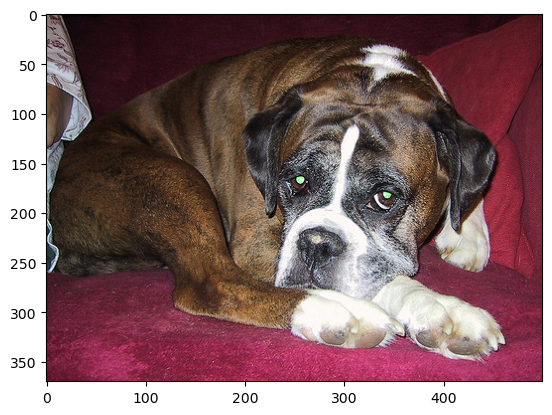

In [44]:
plt.imshow(plt.imread(image_path));

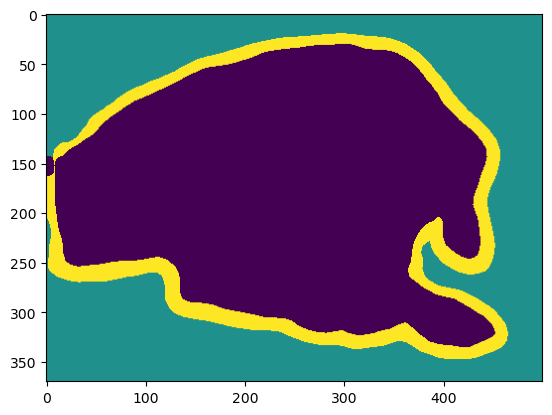

In [52]:
plt.imshow(mask);

In [56]:
print(dir(data_channel['validation_annotation']))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_hub_access_config', 'add_model_access_config', 'config']


In [57]:
print(data_channel['validation_annotation'].config)


{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://pets-data-303/validation_annotation', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'image/png'}


In [58]:
pip install boto3


Note: you may need to restart the kernel to use updated packages.


In [59]:
import boto3

s3 = boto3.client('s3')
bucket_name = "pets-data-303"  # Extracted from S3Uri
prefix = "validation_annotation/"  # Folder inside the bucket

# List the files in the annotation folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
files = [obj['Key'] for obj in response.get('Contents', [])]

print("Files in validation_annotation:", files)


Files in validation_annotation: ['validation_annotation/Abyssinian_10.png', 'validation_annotation/Abyssinian_101.png', 'validation_annotation/Abyssinian_103.png', 'validation_annotation/Abyssinian_107.png', 'validation_annotation/Abyssinian_108.png', 'validation_annotation/Abyssinian_109.png', 'validation_annotation/Abyssinian_110.png', 'validation_annotation/Abyssinian_111.png', 'validation_annotation/Abyssinian_114.png', 'validation_annotation/Abyssinian_116.png', 'validation_annotation/Abyssinian_118.png', 'validation_annotation/Abyssinian_121.png', 'validation_annotation/Abyssinian_122.png', 'validation_annotation/Abyssinian_124.png', 'validation_annotation/Abyssinian_126.png', 'validation_annotation/Abyssinian_13.png', 'validation_annotation/Abyssinian_130.png', 'validation_annotation/Abyssinian_131.png', 'validation_annotation/Abyssinian_133.png', 'validation_annotation/Abyssinian_134.png', 'validation_annotation/Abyssinian_135.png', 'validation_annotation/Abyssinian_138.png', '

In [60]:
from io import BytesIO
from PIL import Image
import numpy as np

# Select one annotation file (adjust index as needed)
annotation_file = files[0]  # Change this to the right file

# Download the file
s3_response = s3.get_object(Bucket=bucket_name, Key=annotation_file)
image_data = s3_response['Body'].read()

# Convert to NumPy array
image = Image.open(BytesIO(image_data)).convert('L')  # Convert to grayscale
ground_truth = np.array(image)

print("Ground truth shape:", ground_truth.shape)


Ground truth shape: (500, 375)


In [61]:
from PIL import Image

# Convert predicted mask to a NumPy array
predicted_mask = np.array(Image.fromarray(mask).resize((375, 500), Image.NEAREST))

print("Predicted mask shape:", predicted_mask.shape)


Predicted mask shape: (500, 375)


Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [76]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

[03/30/25 09:23:38] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            ]8;id=281602;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=884437;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Deleting endpoint with name:                                           ]8;id=520468;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=172335;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4903\4903]8;;\
                             semantic-segmentation-2025-03-30-09-14-40-144                                         